<a href="https://colab.research.google.com/github/navyadeshmukh/vision-modelx/blob/main/CNNs/CIFAR10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of an image recognition model on the CIFAR-10 dataset using a ResNet-style architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is not available.


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
# each epoch, your model sees slightly different versions of the same images.

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform= train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform= test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

num_classes = ('airplane' , 'automobile' , 'ship' , 'truck' , 'bird' , 'cat' , 'deer' , 'dog' , 'frog' , 'horse' )

100%|██████████| 170M/170M [00:07<00:00, 24.2MB/s]


In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size =3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.residual(x) + self.shortcut(x))


In [ ]:
class Resnet18(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(Resnet18, self).__init__()

        self.features = nn.Sequential(
            BasicBlock(in_channel, 64, stride=1),
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 256, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4,128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, len(num_classes)) # Fix: Use the length of the tuple
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
model = Resnet18(3, num_classes)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

t_loss = []
t_accuracy = []

for epoch in range(200):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        inputs = images.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0) # Use labels.size(0) to get the number of items in the batch
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    acc = 100. * correct/total
    if((epoch+1) % 10 == 0):
        print(f'Epoch {epoch+1}, Loss: {avg_loss: .4}, Accuracy: {acc : .2f}%')

    t_loss.append(avg_loss)
    t_accuracy.append(acc)

Epoch 10, Loss:  0.8313, Accuracy:  71.85%
Epoch 20, Loss:  0.5895, Accuracy:  80.55%
Epoch 30, Loss:  0.463, Accuracy:  84.70%
Epoch 40, Loss:  0.3745, Accuracy:  87.86%
Epoch 50, Loss:  0.311, Accuracy:  89.84%
Epoch 60, Loss:  0.2588, Accuracy:  91.47%
Epoch 70, Loss:  0.223, Accuracy:  92.81%
Epoch 80, Loss:  0.1879, Accuracy:  93.80%
Epoch 90, Loss:  0.1669, Accuracy:  94.61%
Epoch 100, Loss:  0.1517, Accuracy:  94.99%
Epoch 110, Loss:  0.1276, Accuracy:  95.85%
Epoch 120, Loss:  0.1128, Accuracy:  96.29%
Epoch 130, Loss:  0.1023, Accuracy:  96.67%
Epoch 140, Loss:  0.09503, Accuracy:  96.89%
Epoch 150, Loss:  0.0864, Accuracy:  97.21%


In [ ]:
import torch
torch.save(model.state_dict(), "resnetCIFAR200ep_weights.pth")

In [ ]:
import os
if os.path.exists("resnetCIFAR_weights.pth"):
    print("✅ File exists.")
else:
    print("❌ File not found.")


print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())

model = Resnet18(3, num_classes)
model.to(device)
model.load_state_dict(torch.load("resnetCIFAR_weights.pth", map_location=torch.device('cpu')))
model.eval()

✅ File exists.
Current working directory: /content
Files in current directory: ['.config', 'resnetCIFAR_weights.pth', 'data', 'sample_data']


Resnet18(
  (features): Sequential(
    (0): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) # Move data to the same device as the model

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Test Accuracy: {100 * correct // total} %')

Final Test Accuracy: 88 %


In [ ]:
import matplotlib.pyplot as plt

# Assuming t_loss and t_accuracy are already populated during training

epochs = range(1, len(t_loss) + 1)

# Plot Loss vs. Epoch
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, t_loss)
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Plot Accuracy vs. Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in t_accuracy])
plt.title('Training Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')


plt.tight_layout()
plt.show()

![image.png]()
![image.png]()

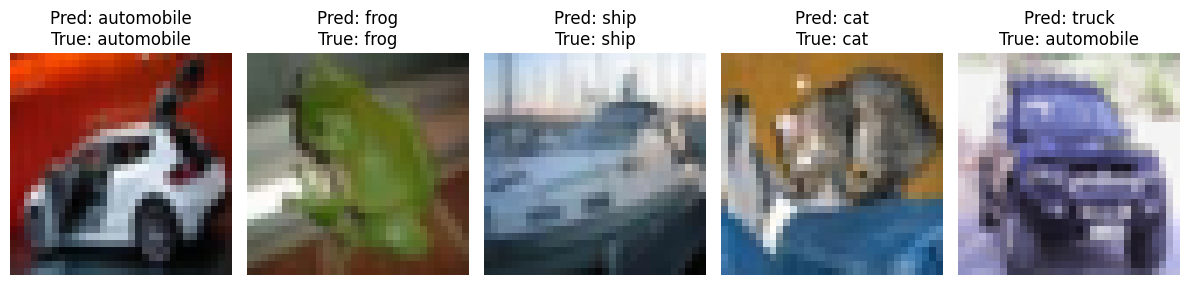

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get one batch from testloader
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        break  # Only first batch

# Move tensors to CPU and convert to NumPy
X_test = images.cpu().numpy()
y_test = labels.cpu().numpy()
predictions = predicted.cpu().numpy()

# Unnormalize image data (assuming normalization was mean=0.5, std=0.5)
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
X_test = X_test * std.reshape(1, 3, 1, 1) + mean.reshape(1, 3, 1, 1)
X_test = np.clip(X_test, 0, 1)  # Clip to [0, 1] range

# 🔄 Shuffle images, labels, and predictions **together**
combined = list(zip(X_test, y_test, predictions))
np.random.shuffle(combined)
X_test, y_test, predictions = zip(*combined)

# Convert back to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
predictions = np.array(predictions)

# 🏷️ Class names (edit as per your dataset)
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']  # Example: CIFAR-10

# 📊 Plot images with predictions and true labels
plt.figure(figsize=(12, 4))
for i in range(5):
    image = X_test[i].transpose((1, 2, 0))  # CHW -> HWC
    true_label = y_test[i]
    predicted_label = predictions[i]

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {num_classes[predicted_label]}\nTrue: {num_classes[true_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
